<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/2024-12-13-palladium-foil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/2024-12-13-palladium-foil.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 2024-12-13 Palladium foil

A 103.8 mg Palladium foil is gas loaded with deuterium, in a 0.59L chamber.

In [29]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

Cloning into 'arpa-e-experiments'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 70 (delta 21), reused 52 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 20.69 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (39/39), done.


In [30]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

In [31]:
meta = {
    "descriptor" : "Palladium foil" # This will go into the title of all plots
}

## Reading the raw data

### Temperature

In [32]:
# Read the tempearture data
temperature_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/new-chamber-first-pd-5.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [33]:
# Print out basic description of the data, including any NaNs
print_info(temperature_df)

Measurements start at: 2024-12-12 18:00:00.336298
Measurements end at: 2024-12-12 18:00:00.336298
---------
Total number of measurements: 303368
Time between measurements: 0.0 s
---------
Total number of NaNs
ambient-RTD     0
chamber-RTD1    0
chamber-RTD2    0
ambient-TC      0
dtype: int64


We're interested in using `chamber-RTD1` and `chamber-RTD2` to get a sense of the tempreature near the sample. Let's see how close they are to one another.

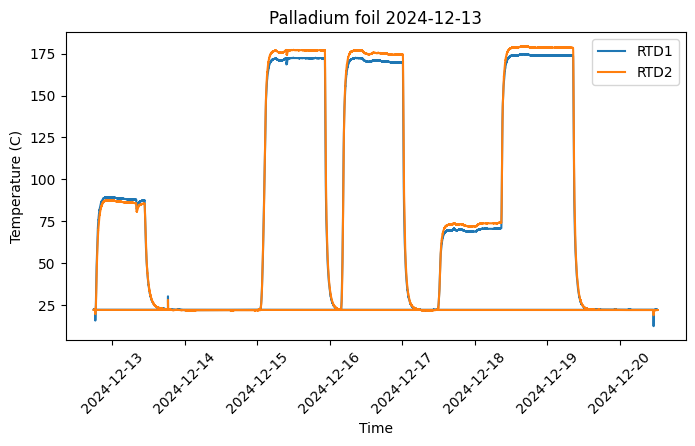

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(temperature_df['chamber-RTD1'], label="RTD1")
plt.plot(temperature_df['chamber-RTD2'], label="RTD2")
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} 2024-12-13")
plt.legend()
plt.show()

We'll take an average of the RTD's and call it `Temperature (C)`

In [35]:
temperature_df['Temperature (C)'] = (temperature_df['chamber-RTD1'] + temperature_df['chamber-RTD2']) / 2

### Heating power

In [36]:
# Read the heating power data
heating_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/new-chamber-first-pd-1.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [37]:
# Print out basic description of the data, including any NaNs
print_info(heating_df)

Measurements start at: 2024-12-12 18:00:04.338145
Measurements end at: 2024-12-20 12:28:33.048885
---------
Total number of measurements: 105774
Time between measurements: 6.346632 s
---------
Total number of NaNs
Output voltage (V)    0
Output current (A)    0
Output power (W)      0
Set voltage (V)       0
Set current (A)       0
dtype: int64


We'll rename "Output power" to just "Power" convenience in plotting

In [38]:
heating_df.rename(columns={'Output power (W)': 'Power (W)'}, inplace=True)

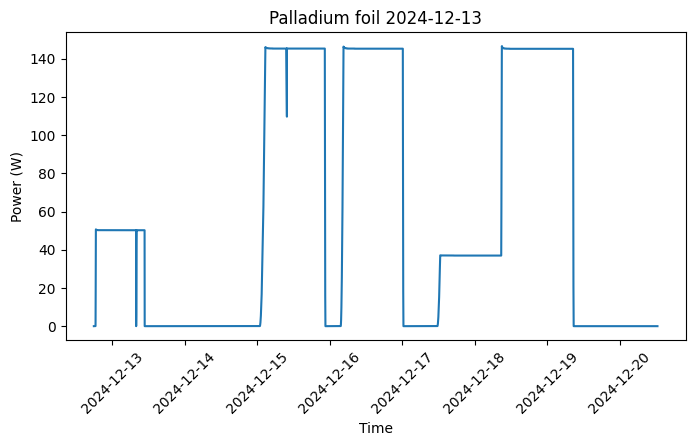

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(heating_df['Power (W)'], label="Power (W)")
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} 2024-12-13")
plt.show()

### Pressure

In [40]:
# Read the pressure data
pressure_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/new-chamber-first-pd-3.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time',
)

In [41]:
# Print out basic description of the data, including any NaNs
print_info(pressure_df)

Measurements start at: 2024-12-12 18:00:03.296090
Measurements end at: 2024-12-20 12:28:33.008194
---------
Total number of measurements: 65297
Time between measurements: 10.280866 s
---------
Total number of NaNs
Voltage Ch3 (V)       0
Pressure Ch3 (bar)    0
dtype: int64


We'll rename the pressure and remove the Ch3 for convenience in plotting.

In [42]:
pressure_df.rename(columns={'Pressure Ch3 (bar)': 'Pressure (Bar)'}, inplace=True)

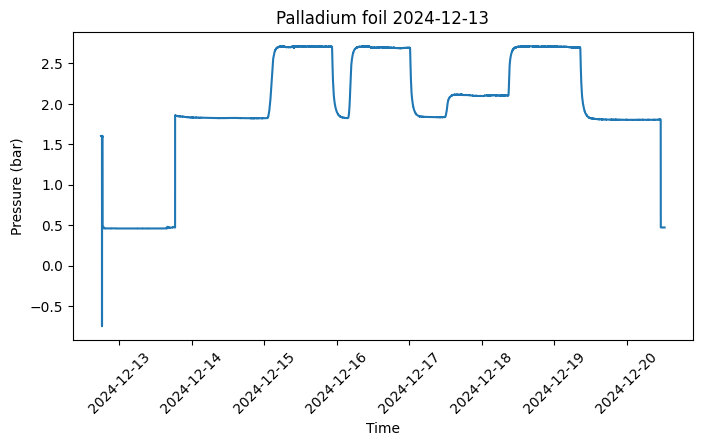

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(pressure_df['Pressure (Bar)'])
plt.xlabel('Time')
plt.ylabel('Pressure (bar)')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} 2024-12-13")
plt.show()

## Processing the data

### Corrupt data

There looks like there is some spikes in the data near start and end of the experiment but these are not important because the true start and end of the experiment are around 2024-12-14 and 2024-12-20.

When we combine the data, we'll cut off the earlier and later times so that we can more easily calculate the deuterium loading.

### Combining data

To derive physical quantities from several diagnostics, we need to have simultaneous measurements. We'll therefore need to do some interpolation of the data. This is going to involve:
1. Mapping all measurements to the nearest second
2. Selecting overlapping time intervals from the data
3. Combining the data from all diagnostics into one dataframe
4. Interpolate to fill the NaNs that result from combining the data in step 3
5. Drop any NaNs that can sometimes be generated at the edges of the time range

In [44]:
combined_df = process_data([temperature_df, pressure_df,heating_df], meta)

In [45]:
combined_df.head()

,ambient-RTD,chamber-RTD1,chamber-RTD2,ambient-TC,Temperature (C),Voltage Ch3 (V),Pressure (Bar),Output voltage (V),Output current (A),Power (W),Set voltage (V),Set current (A)
time,,,,,,,,,,,,
2024-12-12 18:00:13,21.980242,22.103441,21.991880,21.045687,22.047661,2.528197,1.603375,0.0,0.0,0.0,0.0,3.0
2024-12-12 18:00:15,21.980644,22.098627,21.988670,21.035866,22.043649,2.528148,1.603329,0.0,0.0,0.0,0.0,3.0
2024-12-12 18:00:17,21.985661,22.104444,21.991480,21.037140,22.047962,2.528099,1.603284,0.0,0.0,0.0,0.0,3.0
2024-12-12 18:00:20,21.979841,22.109060,21.994490,21.029169,22.051775,2.528050,1.603238,0.0,0.0,0.0,0.0,3.0
2024-12-12 18:00:22,21.976028,22.097824,21.993687,21.011003,22.045755,2.528001,1.603192,0.0,0.0,0.0,0.0,3.0


In [46]:
# Only use times when the experiment was being performed
combined_df = combined_df['2024-12-13 18:32':'2024-12-20 00:00']

### Inferring deuterium loading

The deuterium loading is inferred by using the ideal gas law to calculate how many deuterium molecules are present in the gas over time:

$$N_{D_2} = \frac{PV}{k_B T}$$

and associating any changes $\Delta N_{D_2}$ with deuteium entering the lattice. We can then calculate the loading based on the number of lattice atoms $N_{lattice}$:

$$N_{lattice} = \frac{m_{sample}}{m_{Pd}}$$

$$N_{lattice} = \frac{103.8\times 10^{-6}}{1.77\times 10^{-25}}$$

The loading is then:

$$2\frac{\Delta N_{D_2}}{N_{lattice}}$$

The factor 2 arrises because a single $D_2$ molecule becomes 2 deuterons once inside the lattice.

In [47]:
# Constants
V = 0.59 / 1000  # Volume of the container in m^3
kB = 1.3806503e-23  # Boltzmann constant in J/K
N_lattice = 103.8e-6 / 1.77e-25

In [48]:
combined_df['$D_2$ molecules'] = (combined_df['Pressure (Bar)']*1e5 * V) / (kB * (combined_df['Temperature (C)'] + 273.15))

In [49]:
combined_df['D/Pd Loading'] = 2*(combined_df.iloc[0]['$D_2$ molecules'] - combined_df['$D_2$ molecules']) / N_lattice

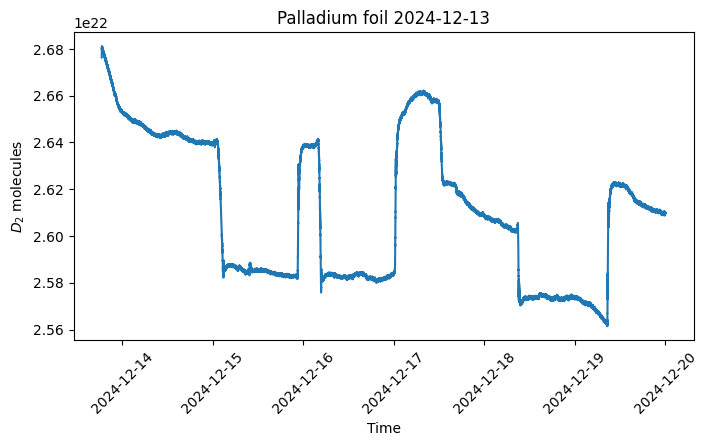

In [50]:
plt.figure(figsize=(8, 4))
plt.plot(combined_df['$D_2$ molecules'])
plt.xlabel('Time')
plt.ylabel('$D_2$ molecules')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} {combined_df.index[0].date()}")
plt.show()

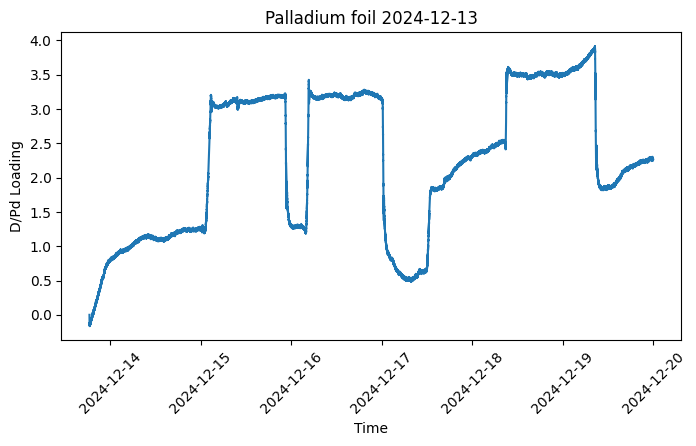

In [51]:
plt.figure(figsize=(8, 4))
plt.plot(combined_df['D/Pd Loading'])
plt.xlabel('Time')
plt.ylabel('D/Pd Loading')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} {combined_df.index[0].date()}")
plt.show()

## Visualising the data

Let's look at the whole data range first

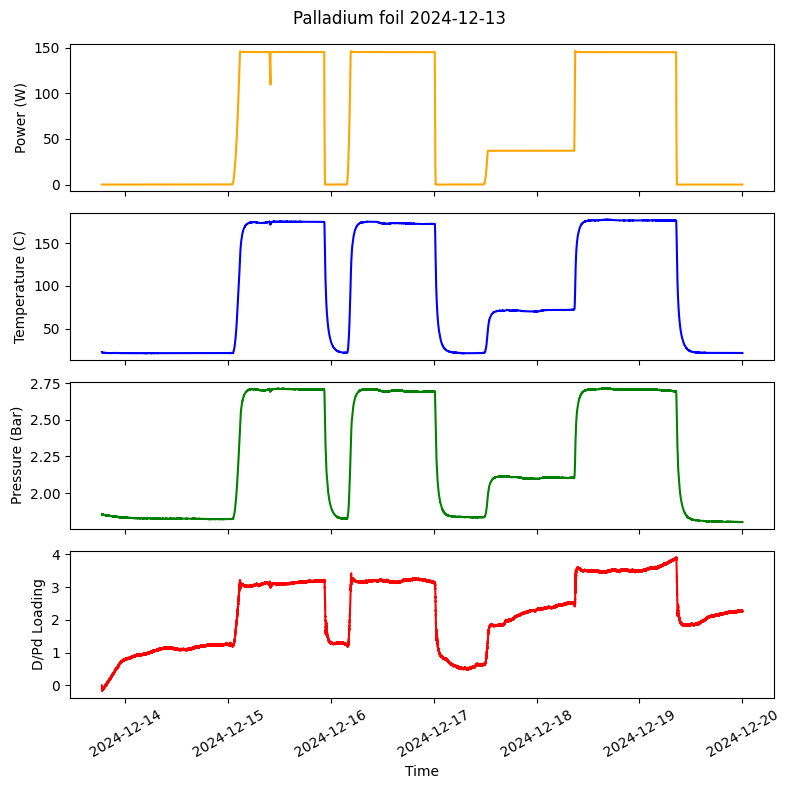

In [52]:
fig, axes = plot_panels(combined_df, ['Power (W)','Temperature (C)', 'Pressure (Bar)', 'D/Pd Loading'],
                        colors=['orange','blue', 'green', 'red'])

Let's also take a look at a pressure/temperature phase space plot, for ideal gas behaviour, we'd expect

$$10^{5}P(atm) = \frac{N_{D_2}k_BT(C)}{V} + \frac{273.15N_{D_2}k_B}{V}$$

Because the number of gas molecules $N_{D_2}$ appears in both the gradient term and offset term, the motion around phase space can look quite complicated. Let's see.

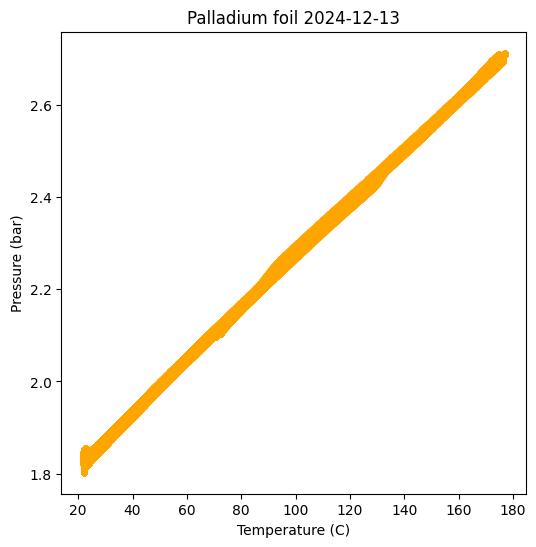

In [53]:
# Create a scatter plot of pressure vs. temperature
plt.figure(figsize=(6, 6))
plt.scatter(combined_df['Temperature (C)'], combined_df['Pressure (Bar)'], marker=".", color='orange', alpha=0.7)

# Label axes
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (bar)')

# Add title
plt.title(f"{meta['descriptor']} {combined_df.index[0].date()}")

# Display the plot
plt.show()

If we down-sample the data a bit, we can get a bit more sense of the dynamics from the scatter plot. It also allows us to see potentially interesting points that we'd like to pay more attention to. For example:

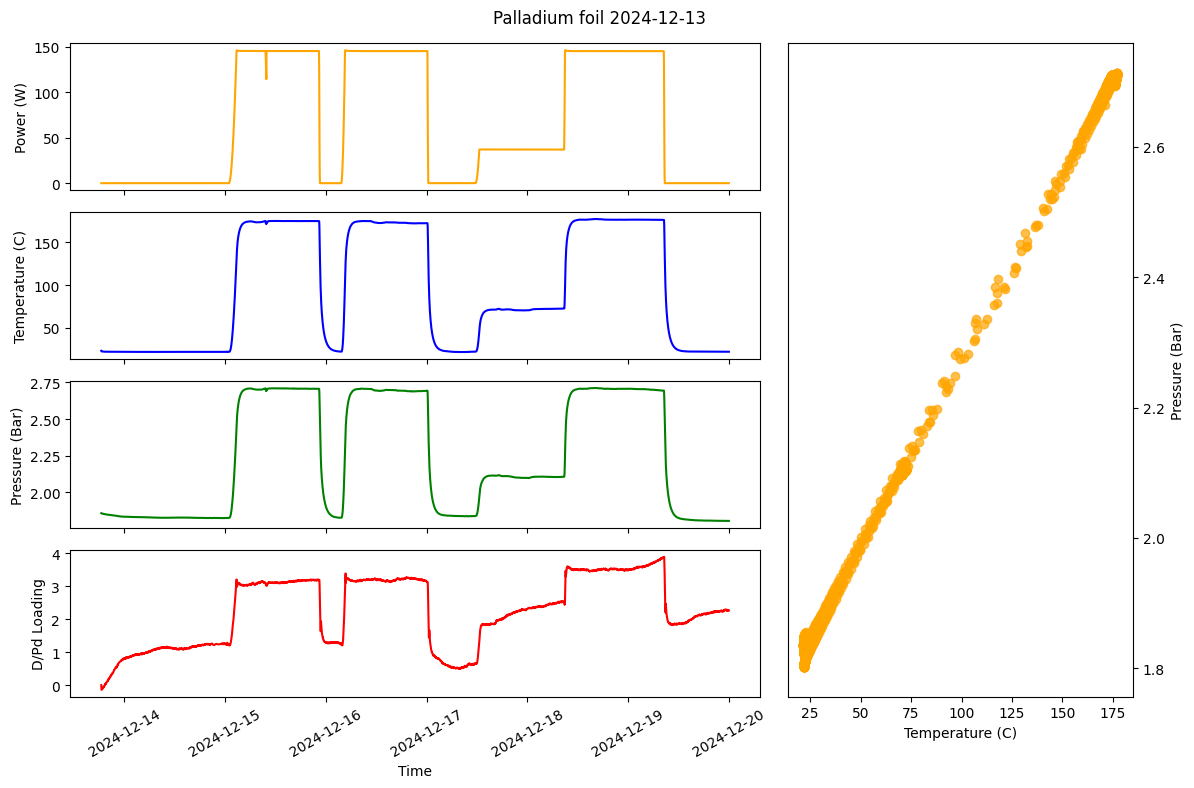

In [54]:
fig, panel_axes, scatter_axes = plot_panels_with_scatter(combined_df, ['Power (W)','Temperature (C)', 'Pressure (Bar)', 'D/Pd Loading'],
                   "Temperature (C)", "Pressure (Bar)",
                        colors=['orange','blue', 'green', 'red'], downsample=100)

Let's now revisit the P-T phase diagram and this time overlay what we would expect from the ideal gas law.

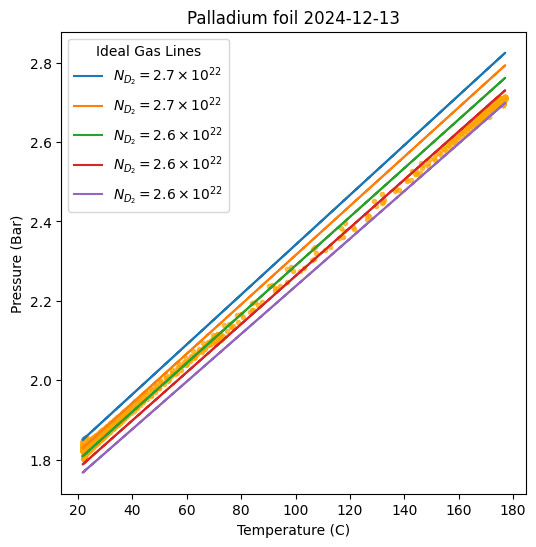

In [55]:
downsample = 100

# Downsample the data
combined_df_downsampled = combined_df.iloc[::downsample]

# Create a scatter plot of pressure vs. temperature
plt.figure(figsize=(6, 6))
plt.scatter(combined_df_downsampled['Temperature (C)'], combined_df_downsampled['Pressure (Bar)'], marker=".", color='orange', alpha=0.7)

# Label axes
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (Bar)')

# Add title
plt.title(f"{meta['descriptor']} {combined_df_downsampled.index[0].date()}")

combined_df['$D_2$ molecules'].min()

# Generate ideal gas lines for different N_D2 values
N_D2_values = np.linspace(combined_df['$D_2$ molecules'].max(),
                          combined_df['$D_2$ molecules'].min(), 5)

# # Add custom values, e.g., 100 and 200
# custom_values = [100, 200]
# N_D2_values = np.append(N_D2_values, custom_values)
# N_D2_values = np.unique(N_D2_values)  # Optional: Remove duplicates and sort

temperatures_C = combined_df_downsampled['Temperature (C)']
temperatures_K = temperatures_C + 273.15  # Convert Celsius to Kelvin

for N_D2 in N_D2_values:
    # Calculate pressure in Pa and convert to Bar (1 Pa = 1e-5 Bar)
    pressures_Pa = (N_D2 * kB * temperatures_K) / V
    pressures_Bar = pressures_Pa * 1e-5

    # Extract the mantissa and exponent separately
    mantissa = f"{N_D2:.1e}".split("e")[0]  # Get the coefficient
    exponent = f"{N_D2:.1e}".split("e")[1]  # Get the exponent, like +21 or +22
    exponent = exponent.replace('+', '')    # Remove any plus sign from the exponent

    # Create the label with explicit LaTeX formatting
    label = f'$N_{{D_2}} = {mantissa} \\times 10^{{{exponent}}}$'

    # Plot the line for this N_D2 value
    plt.plot(temperatures_C, pressures_Bar, label=label)

# Show legend for clarity
plt.legend(title='Ideal Gas Lines')

# Display the plot
plt.show()